In [2]:
import numpy as np
import cvxpy as cp
from scipy.spatial.distance import cdist
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy.special import gamma
import itertools
import time
import mosek
from mpl_toolkits.axes_grid1.inset_locator import mark_inset, zoomed_inset_axes
import pandas as pd

In [3]:
def plot_eval(df, quantiles, df1=None, quantiles1=None,end_ind=61,j=(0,0,0), q = (40,60),K=5, alpha=0.1):
    j1,j2,j3 = j
    # Set up LaTeX rendering
    df = df[K]
    fontsize= 10
    quantiles = quantiles[K]
    q1,q2 = q
    plt.rcParams.update({
        "text.usetex": True,
        "font.family": "serif",
        "font.serif": ["Computer Modern Roman"],
        "font.size": fontsize,
        "axes.labelsize": fontsize,
        "axes.titlesize": 12,
        "legend.fontsize": fontsize
    })
    t_range = np.array(df['t'])[(0*end_ind)+1:(1)*end_ind:2]
    plt.figure(figsize=(3, 2), dpi=300)
    plt.plot(t_range, df['O_eval0'][(j1*end_ind)+1:(j1+1)*end_ind:2], 'b-', linewidth=1, label = "online clustering")

    plt.fill_between(np.array(t_range),y1=np.array(quantiles[q1]['O_eval0'][(j1*end_ind)+1:(j1+1)*end_ind:2]).astype(float),y2=np.array(quantiles[q2]['O_eval0'][(j1*end_ind)+1:(j1+1)*end_ind:2]).astype(float),alpha=alpha, color = 'b')
    plt.plot(t_range, df['MRO_eval0'][(j2*end_ind)+1:(j2+1)*end_ind:2], 'r-', linewidth=1, label = "reclustering")
    plt.fill_between(np.array(t_range),y1=np.array(quantiles[q1]['MRO_eval0'][(j2*end_ind)+1:(j2+1)*end_ind:2]).astype(float),y2=np.array(quantiles[q2]['MRO_eval0'][(j2*end_ind)+1:(j2+1)*end_ind:2]).astype(float),alpha=alpha, color='r')

    # plt.plot(t_range, df1['SA_eval1'][(j3*end_ind):(j3+1)*end_ind-1:2], 'g-', linewidth=1, label = "SAA")
    # plt.fill_between(np.array(t_range),y1=np.array(quantiles1[q1]['SA_eval1'][(j3*end_ind)+1:(j3+1)*end_ind:2]).astype(float),y2=np.array(quantiles1[q2]['SA_eval1'][(j3*end_ind)+1:(j3+1)*end_ind:2]).astype(float),alpha=alpha, color='g')
    # plt.ylim([0.008,0.022])
    plt.legend()
    plt.xlabel(r'Time step $(t)$')
    plt.title(r'Out-of-sample expected value')
    plt.grid(True, alpha=alpha)
    plt.savefig('eval_analysis.pdf', bbox_inches='tight', dpi=300)


In [4]:
def plot_obj(df, quantiles, df1=None, quantiles1=None,end_ind=61,j=(0,0,0), q = (40,60),K=5, alpha=0.1):
    j1,j2,j3 = j
    # Set up LaTeX rendering
    df = df[K]
    fontsize= 10
    quantiles = quantiles[K]
    q1,q2 = q
    plt.rcParams.update({
        "text.usetex": True,
        "font.family": "serif",
        "font.serif": ["Computer Modern Roman"],
        "font.size": fontsize,
        "axes.labelsize": fontsize,
        "axes.titlesize": 12,
        "legend.fontsize": fontsize
    })
    t_range = np.array(df['t'])[(0*end_ind)+1:(1)*end_ind:2]
    plt.figure(figsize=(3, 2), dpi=300)
    plt.plot(t_range, df['obj_values'][(j1*end_ind)+1:(j1+1)*end_ind:2], 'b-', linewidth=1, label = "online clustering")

    plt.fill_between(np.array(t_range),y1=np.array(quantiles[q1]['obj_values'][(j1*end_ind)+1:(j1+1)*end_ind:2]).astype(float),y2=np.array(quantiles[q2]['obj_values'][(j1*end_ind)+1:(j1+1)*end_ind:2]).astype(float),alpha=alpha, color = 'b')
    plt.plot(t_range, df['MRO_worst_values'][(j2*end_ind)+1:(j2+1)*end_ind:2], 'r-', linewidth=1, label = "reclustering")
    plt.fill_between(np.array(t_range),y1=np.array(quantiles[q1]['MRO_worst_values'][(j2*end_ind)+1:(j2+1)*end_ind:2]).astype(float),y2=np.array(quantiles[q2]['MRO_worst_values'][(j2*end_ind)+1:(j2+1)*end_ind:2]).astype(float),alpha=alpha, color='r')

    # plt.plot(t_range, df1['SA_eval1'][(j3*end_ind):(j3+1)*end_ind-1:2], 'g-', linewidth=1, label = "SAA")
    # plt.fill_between(np.array(t_range),y1=np.array(quantiles1[q1]['SA_eval1'][(j3*end_ind)+1:(j3+1)*end_ind:2]).astype(float),y2=np.array(quantiles1[q2]['SA_eval1'][(j3*end_ind)+1:(j3+1)*end_ind:2]).astype(float),alpha=alpha, color='g')
    # plt.ylim([0.008,0.022])
    plt.legend()
    plt.xlabel(r'Time step $(t)$')
    plt.title(r'In-sample objective value')
    plt.grid(True, alpha=alpha)
    plt.savefig('obj_analysis_T.pdf', bbox_inches='tight', dpi=300)


In [18]:
def plot_computation_times_iter(df, quantiles, df1=None, quantiles1=None, end_ind=61,j=(0,0,0), q = (40,60),K=5, alpha=0.1):
    j1,j2,j3 = j
    df = df[K]
    fontsize= 10
    quantiles = quantiles[K]
    q1,q2 = q
    # Set up LaTeX rendering
    plt.rcParams.update({
        "text.usetex": True,
        "font.family": "serif",
        "font.serif": ["Computer Modern Roman"],
        "font.size": fontsize
    })
    t_range = np.array(df['t'])[(0*end_ind)+1:(1)*end_ind:2]
    plt.figure(figsize=(3, 2), dpi=300)
    plt.plot(t_range, df['online_time'][(j1*end_ind)+1:(j1+1)*end_ind:2], 'b-', linewidth=1, label = "online clustering")
    plt.plot(t_range, np.array(df['MRO_time'][(j2*end_ind)+1:(j2+1)*end_ind:2])+np.array(df['MRO_worst_times'][(j1*end_ind)+1:(j1+1)*end_ind:2]), 'r-', linewidth=1, label = "reclustering")
    plt.fill_between(np.array(t_range),y1=np.array(quantiles[q1]['online_time'][(j1*end_ind)+1:(j1+1)*end_ind:2]).astype(float),y2=np.array(quantiles[q2]['online_time'][(j1*end_ind)+1:(j1+1)*end_ind:2]).astype(float),alpha=alpha, color = 'b')
    plt.fill_between(np.array(t_range),y1=np.array(quantiles[q1]['MRO_time'][(j2*end_ind)+1:(j2+1)*end_ind:2]).astype(float)+np.array(quantiles[q1]['MRO_worst_times'][(j2*end_ind)+1:(j2+1)*end_ind:2]).astype(float),y2=np.array(quantiles[q2]['MRO_time'][(j2*end_ind)+1:(j2+1)*end_ind:2]).astype(float)+np.array(quantiles[q2]['MRO_worst_times'][(j2*end_ind)+1:(j2+1)*end_ind:2]).astype(float),alpha=alpha, color = 'r')

    # plt.plot(t_range, df['worst_times'][(j1*end_ind)+1:(j1+1)*end_ind:2], 'b-.', linewidth=1, label = r"online clustering $\hat{H}^K_t$")
    # plt.plot(t_range, df['MRO_worst_times'][(j1*end_ind)+1:(j1+1)*end_ind:2], 'r-.', linewidth=1, label = r"reclustering $\hat{H}^K_t$")
    # plt.fill_between(np.array(t_range),y1=np.array(quantiles[q1]['worst_times'][(j1*end_ind)+1:(j1+1)*end_ind:2]).astype(float),y2=np.array(quantiles[q2]['worst_times'][(j1*end_ind)+1:(j1+1)*end_ind:2]).astype(float),alpha=alpha, color = 'b')
    # plt.fill_between(np.array(t_range),y1=np.array(quantiles[q1]['MRO_worst_times'][(j2*end_ind)+1:(j2+1)*end_ind:2]).astype(float),y2=np.array(quantiles[q2]['MRO_worst_times'][(j2*end_ind)+1:(j2+1)*end_ind:2]).astype(float),alpha=alpha, color = 'r')

    # plt.plot(t_range, df1['DRO_time'][(j3*end_ind)+1:(j3+1)*end_ind:2], color ='black', linewidth=1, label = "DRO")
    # plt.plot(t_range, df1['SA_time'][(j3*end_ind)+1:(j3+1)*end_ind:2], color ='g', linewidth=1, label = "SAA")
    # plt.fill_between(np.array(t_range),y1=np.array(quantiles1[q1]['DRO_time'][(j3*end_ind)+1:(j3+1)*end_ind:2]).astype(float),y2=np.array(quantiles1[q2]['DRO_time'][(j3*end_ind)+1:(j3+1)*end_ind:2]).astype(float),alpha=alpha, color = 'black')
    # plt.fill_between(np.array(t_range),y1=np.array(quantiles1[q1]['SA_time'][(j3*end_ind)+1:(j3+1)*end_ind:2]).astype(float),y2=np.array(quantiles1[q2]['SA_time'][(j3*end_ind)+1:(j3+1)*end_ind:2]).astype(float),alpha=alpha, color = 'g')

    plt.legend()
    plt.xlabel(r'Time step $(t)$')
    plt.title(r'Compuation time per iteration (s)')
    plt.grid(True, alpha=0.3)
    plt.yscale("log")
    plt.savefig('time_iters_T.pdf', bbox_inches='tight', dpi=300)

In [6]:
def plot_satisfy(df, df1=None,end_ind=61,j=(0,0,0),K=5):
    # Set up LaTeX rendering
    j1,j2,j3 = j
    df = df[K]
    fontsize= 10
    plt.rcParams.update({
        "text.usetex": True,
        "font.family": "serif",
        "font.serif": ["Computer Modern Roman"],
        "font.size": fontsize,
        "axes.labelsize": fontsize,
        "axes.titlesize": fontsize,
        "legend.fontsize": fontsize
    })
    t_range = df['t'][(0*end_ind)+1:(1)*end_ind:2]
    plt.figure(figsize=(6, 3), dpi=300)
    plt.plot(t_range, df['O_satisfy1'][(j1*end_ind)+1:(j1+1)*end_ind:2], 'b-', linewidth=1, label = "online clustering")
    plt.plot(t_range, df['MRO_satisfy1'][(j2*end_ind)+1:(j2+1)*end_ind:2], 'r-', linewidth=1, label = "reclustering")


    # plt.plot(t_range, df['O_worst_satisfy1'][(j1*end_ind)+1:(j1+1)*end_ind:2], 'b-.', linewidth=1, label = "online clustering worst")
    plt.plot(t_range, df['MRO_worst_satisfy1'][(j2*end_ind)+1:(j2+1)*end_ind:2], 'r-.', linewidth=1, label = "reclustering worst")
    plt.plot(t_range, df1['SA_satisfy1'][(j3*end_ind):(j3+1)*end_ind-1:2], 'g-', linewidth=1, label = "SAA")
    # plt.plot(t_range, df1['DRO_satisfy1'][(j3*end_ind):(j3+1)*end_ind-1:2], color ='black', linewidth=1, label = "DRO")
    plt.legend()
    plt.xlabel(r'Time step $(t)$')
    plt.ylabel(r'Confidence')
    plt.grid(True, alpha=0.3)
    plt.savefig('prob_analysis.pdf', bbox_inches='tight', dpi=300)


In [ ]:
def plot_dists(df, quantiles, end_ind=61, q = (40,60),K=5, alpha=0.1):
    j1,j2 = (0,0)
    df = df[K]
    fontsize= 11
    quantiles = quantiles[K]
    q1,q2 = q
    # Set up LaTeX rendering
    plt.rcParams.update({
        "text.usetex": True,
        "font.family": "serif",
        "font.serif": ["Computer Modern Roman"],
        "font.size": 10,
        "axes.labelsize": 10,
        "axes.titlesize": 12,
        "legend.fontsize": 9
        
    })
    t_range = np.array(df['t'])[(0*end_ind)+1:(1)*end_ind:2]
    plt.figure(figsize=(3, 2), dpi=300)
    plt.plot(t_range, df['mean_val'][(j1*end_ind)+1:(j1+1)*end_ind:2], 'b:', linewidth=1, label = r"online clustering $D_1(K,t)$")
    plt.plot(t_range, df['MRO_mean_val'][(j2*end_ind)+1:(j2+1)*end_ind:2], 'r:', linewidth=1, label = r"reclustering $D_1(K,t)$")
    plt.plot(t_range, df['square_val'][(j1*end_ind)+1:(j1+1)*end_ind:2], 'b-', linewidth=1, label = r"online clustering $D_2(K,t)$")
    plt.plot(t_range, df['MRO_square_val'][(j2*end_ind)+1:(j2+1)*end_ind:2], 'r', linewidth=1, label = r"reclustering $D_2(K,t)$")
    


    plt.fill_between(np.array(t_range),y1=np.array(quantiles[q1]['mean_val'][(j1*end_ind)+1:(j1+1)*end_ind:2]).astype(float),y2=np.array(quantiles[q2]['mean_val'][(j1*end_ind)+1:(j1+1)*end_ind:2]).astype(float),alpha=alpha, color = 'b')
    plt.fill_between(np.array(t_range),y1=np.array(quantiles[q1]['MRO_mean_val'][(j2*end_ind)+1:(j2+1)*end_ind:2]).astype(float),y2=np.array(quantiles[q2]['MRO_mean_val'][(j2*end_ind)+1:(j2+1)*end_ind:2]).astype(float),alpha=alpha, color = 'r')
    plt.fill_between(np.array(t_range),y1=np.array(quantiles[q1]['square_val'][(j1*end_ind)+1:(j1+1)*end_ind:2]).astype(float),y2=np.array(quantiles[q2]['square_val'][(j1*end_ind)+1:(j1+1)*end_ind:2]).astype(float),alpha=alpha, color = 'b')
    plt.fill_between(np.array(t_range),y1=np.array(quantiles[q1]['MRO_square_val'][(j2*end_ind)+1:(j2+1)*end_ind:2]).astype(float),y2=np.array(quantiles[q2]['MRO_square_val'][(j2*end_ind)+1:(j2+1)*end_ind:2]).astype(float),alpha=alpha, color = 'r')

    plt.legend(loc = 'center right',  bbox_to_anchor=(1, 0.6))
    plt.xlabel(r'Time step $(t)$')
    plt.title(r'Clustering distances')
    plt.grid(True, alpha=0.3)
    plt.yscale("log")
    plt.savefig('dist_conv.pdf', bbox_inches='tight', dpi=300)

In [35]:
def plot_dists(df, quantiles, end_ind=61, j = (0,0), q = (40,60),K=5, alpha=0.1):
    j1,j2 = j
    df = df[K]
    fontsize= 11
    quantiles = quantiles[K]
    q1,q2 = q
    # Set up LaTeX rendering
    plt.rcParams.update({
        "text.usetex": True,
        "font.family": "serif",
        "font.serif": ["Computer Modern Roman"],
        "font.size": 10,
        "axes.labelsize": 10,
        "axes.titlesize": 12,
        "legend.fontsize": 9
        
    })
    t_range = np.array(df['t'])[(0*end_ind)+1:(1)*end_ind:2]
    plt.figure(figsize=(3, 2), dpi=300)
    plt.plot(t_range, df['mean_val'][(j1*end_ind)+1:(j1+1)*end_ind:2], 'b:', linewidth=1, label = r"$D_1(K,t)$")
    plt.plot(t_range, df['MRO_mean_val'][(j2*end_ind)+1:(j2+1)*end_ind:2], 'r:', linewidth=1)

    plt.plot(t_range, 5*np.array(df['sig_val'][(j1*end_ind)+1:(j1+1)*end_ind:2]), 'b-.', linewidth=1, label = r"$\Phi(K,t)$")
    plt.plot(t_range, 5*np.array(df['MRO_sig_val'][(j2*end_ind)+1:(j2+1)*end_ind:2]), 'r-.', linewidth=1)

    plt.plot(t_range, df['square_val'][(j1*end_ind)+1:(j1+1)*end_ind:2], 'b-', linewidth=1, label = r"$D_2(K,t)$")
    plt.plot(t_range, df['MRO_square_val'][(j2*end_ind)+1:(j2+1)*end_ind:2], 'r', linewidth=1)


    plt.fill_between(np.array(t_range),y1=np.array(quantiles[q1]['mean_val'][(j1*end_ind)+1:(j1+1)*end_ind:2]).astype(float),y2=np.array(quantiles[q2]['mean_val'][(j1*end_ind)+1:(j1+1)*end_ind:2]).astype(float),alpha=alpha, color = 'b')
    plt.fill_between(np.array(t_range),y1=np.array(quantiles[q1]['MRO_mean_val'][(j2*end_ind)+1:(j2+1)*end_ind:2]).astype(float),y2=np.array(quantiles[q2]['MRO_mean_val'][(j2*end_ind)+1:(j2+1)*end_ind:2]).astype(float),alpha=alpha, color = 'r')
    plt.fill_between(np.array(t_range),y1=np.array(quantiles[q1]['square_val'][(j1*end_ind)+1:(j1+1)*end_ind:2]).astype(float),y2=np.array(quantiles[q2]['square_val'][(j1*end_ind)+1:(j1+1)*end_ind:2]).astype(float),alpha=alpha, color = 'b')
    plt.fill_between(np.array(t_range),y1=np.array(quantiles[q1]['MRO_square_val'][(j2*end_ind)+1:(j2+1)*end_ind:2]).astype(float),y2=np.array(quantiles[q2]['MRO_square_val'][(j2*end_ind)+1:(j2+1)*end_ind:2]).astype(float),alpha=alpha, color = 'r')

    plt.fill_between(np.array(t_range),y1=5*np.array(quantiles[q1]['sig_val'][(j1*end_ind)+1:(j1+1)*end_ind:2]).astype(float),y2=5*np.array(quantiles[q2]['sig_val'][(j1*end_ind)+1:(j1+1)*end_ind:2]).astype(float),alpha=alpha, color = 'b')
    plt.fill_between(np.array(t_range),y1=5*np.array(quantiles[q1]['MRO_sig_val'][(j2*end_ind)+1:(j2+1)*end_ind:2]).astype(float),y2=5*np.array(quantiles[q2]['MRO_sig_val'][(j2*end_ind)+1:(j2+1)*end_ind:2]).astype(float),alpha=alpha, color = 'r')

    plt.legend(loc = 'center right',  bbox_to_anchor=(1, 0.7))
    plt.xlabel(r'Time step $(t)$')
    plt.title(r'Clustering distances')
    plt.grid(True, alpha=0.3)
    plt.yscale("log")
    plt.savefig('dist_conv.pdf', bbox_inches='tight', dpi=300)

In [30]:
T=10001
R = 40
K_list = [0,15]
eps_init = [0.005,0.0048,0.0015]
M = len(eps_init)
quant_list = [25,75]
foldername = '/Users/irina.wang/Desktop/Princeton/Project2/mro_mpc/portfolio_exp/ver1/T'+str(T-1)+'R'+str(R)+'/'
folderout = '/Users/irina.wang/Desktop/Princeton/Project2/mro_mpc/portfolio_exp/ver1/T'+str(T-1)+'/'
# setup MRO dfs
def setup_dfs(init = False):
    if init:
        quantiles = {}
        for K in K_list:
            dfs_list = []
            for r in range(R):
                newdf = pd.read_csv(foldername + 'df_' + 'K'+str(K)+'R'+ str(r) +'.csv')
                dfs_list.append(newdf)
            df1 = dfs_list[0]
            quantiles[K] = {}
            for quant in quant_list:
                quantiles[K][quant] = pd.DataFrame(index=df1.index, columns=df1.columns)
                # Calculate quantiles for each entry
                for i in range(len(df1.index)):
                    for j in range(len(df1.columns)):
                        values = [dfs_list[k].iloc[i, j] for k in range(len(dfs_list))]
                        quantiles[K][quant].iloc[i, j] = np.percentile(values, quant)
                quantiles[K][quant].to_csv(folderout+'quantiles_'+ str(quant)+'K'+str(K)+'.csv')
            sum_df = dfs_list[0].copy()
            for dfs in dfs_list[1:]:
                sum_df = sum_df.add(dfs, fill_value=0)
            sum_df = sum_df/(R)
            sum_df.to_csv(folderout+'df_'+ 'K'+str(K)+'.csv')
    df = {}
    quantiles = {}
    for K in K_list:
        df[K] = pd.read_csv(folderout+'df_' + 'K'+str(K)+'.csv')
        quantiles[K] = {}
        for quant in quant_list:
            quantiles[K][quant] = pd.read_csv(folderout+'quantiles_'+ str(quant)+'K'+str(K)+'.csv')
    return df, quantiles

In [11]:
df, quantiles = setup_dfs(init = False)

In [106]:
returns = pd.read_csv('/Users/irina.wang/Desktop/Princeton/Project2/mro_mpc/portfolio_time/sp500_synthetic_returns.csv').to_numpy()[:,1:]

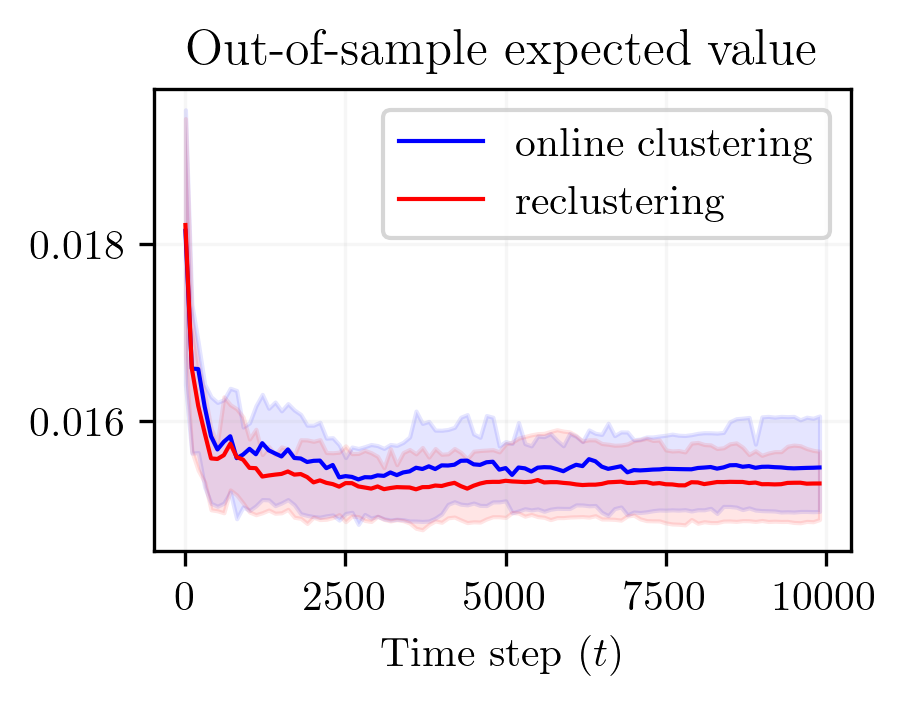

In [12]:
# K = K_list[4]
# plot_eval(df,quantiles,df[0],quantiles[0],j=(1,7,0),K=15,q=(25,75), dro=True,end_ind = 201)

K = 15
plot_eval(df,quantiles,df[0],quantiles[0],j=(2,3,0),K=15,q=(25,75),end_ind = 201)

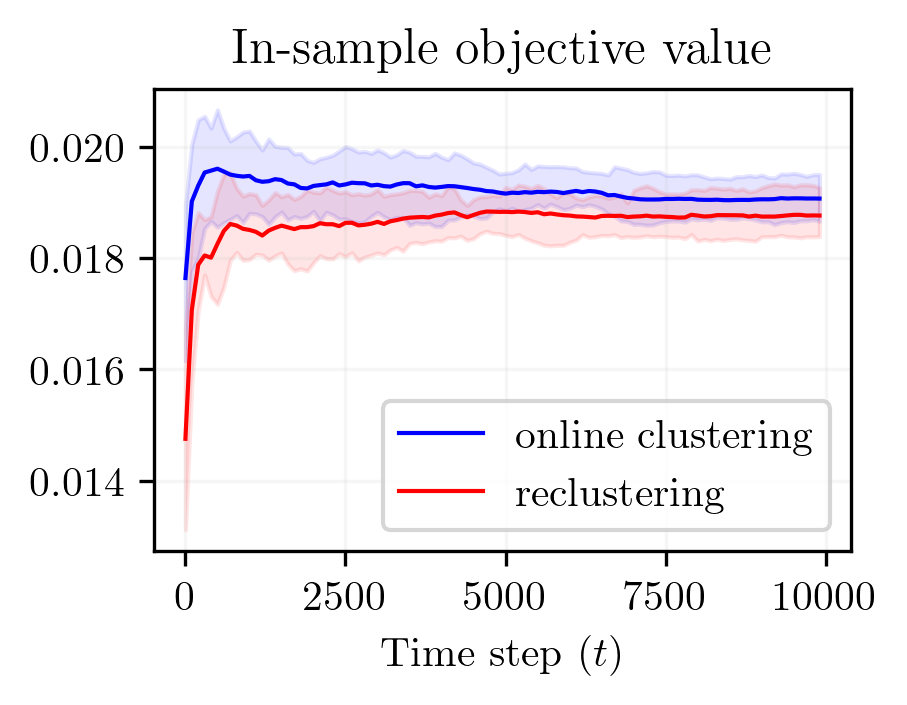

In [13]:
# K = K_list[4]
# plot_eval(df,quantiles,df[0],quantiles[0],j=(1,7,0),K=15,q=(25,75), dro=True,end_ind = 201)

K = 15
plot_obj(df,quantiles,df[0],quantiles[0],j=(2,3,0),K=15,q=(25,75),end_ind = 201)

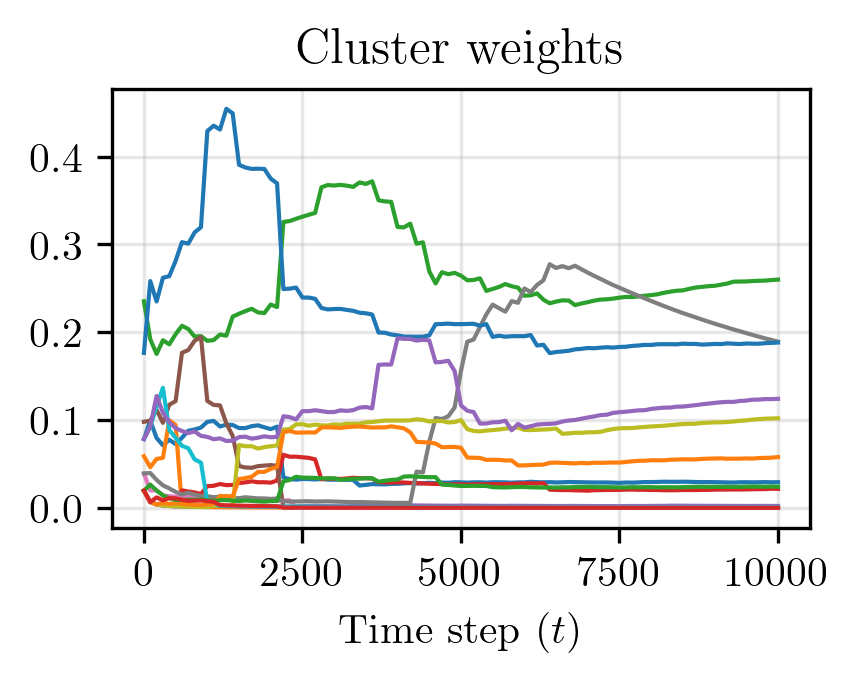

In [10]:
def tofloatarray(string):
    string = string.replace('[', '').replace(']', '')
    return np.fromstring(string, sep=' ')

def pad_array(array, K):
    num_zeros = K - len(array)
    return np.concatenate((array, np.zeros(num_zeros)))

dfw = pd.read_csv(folderout+'df_weights.csv')
kweights = np.vstack([tofloatarray(dfw['weights'][j]) for j in range(201) ])
MRO_kweights = np.vstack([tofloatarray(dfw['MRO_weights'][j]) for j in range(201) ])

plt.rcParams.update({
        "text.usetex": True,
        "font.family": "serif",
        "font.serif": ["Computer Modern Roman"],
        "font.size": 10,
        "axes.labelsize": 10,
        "axes.titlesize": 12,
        "legend.fontsize": 9
        
    })
plt.figure(figsize=(3, 1.9), dpi=300)
for j in range(15):
  plt.plot(dfw['t'][:201:2],kweights[:,j][::2], linewidth = 1)
plt.xlabel(r'Time step $(t)$')
plt.title(r'Cluster weights')
plt.grid(True, alpha=0.3)
plt.savefig('weights.pdf', bbox_inches='tight', dpi=300)

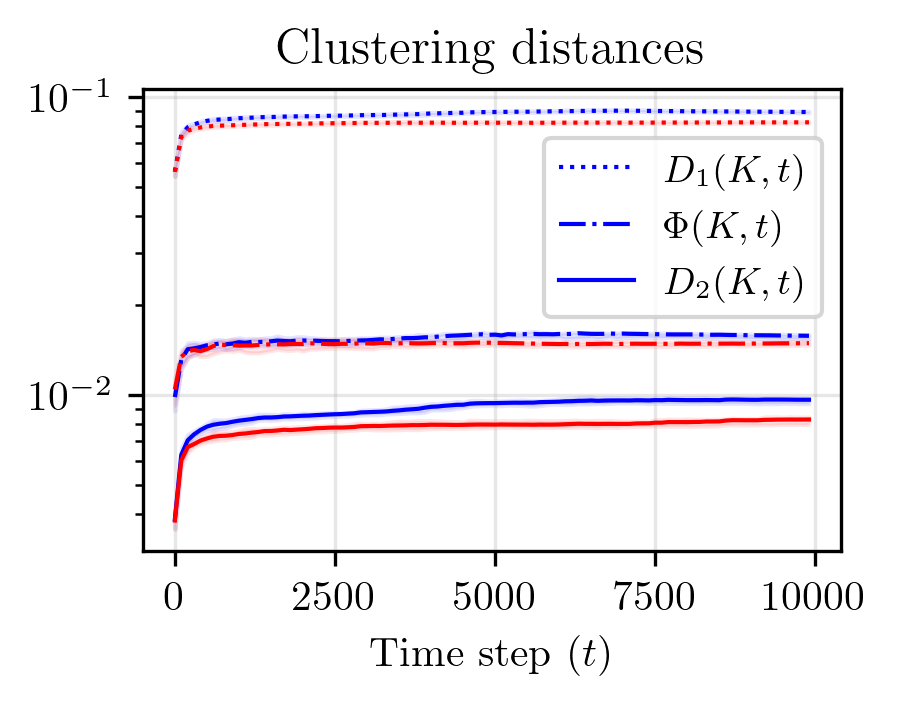

In [36]:
plot_dists(df,quantiles,q = (25,75),j = (2,3), end_ind=201,K=K)

python(40698) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(40725) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(40726) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(40727) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


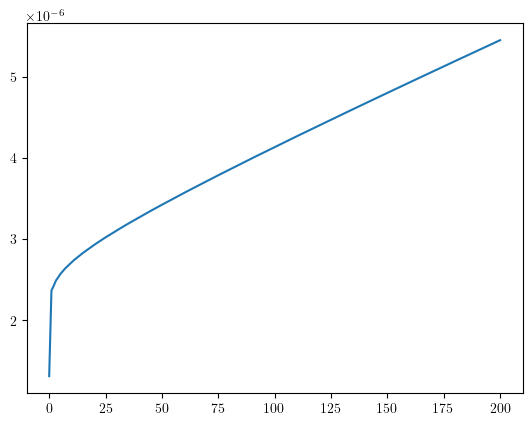

In [40]:
plt.plot(np.cumsum(df[15]['regret_bound'][:201])/20000)

/var/folders/yj/ns1g3ynx5sq0b0747kq8nz21t6q45w/T/ipykernel_32700/3064772499.py:1: RuntimeWarning: invalid value encountered in double_scalars
  plt.plot([np.sum(df[15]['regret_bound'][:i])/(i) for i in range(201)])


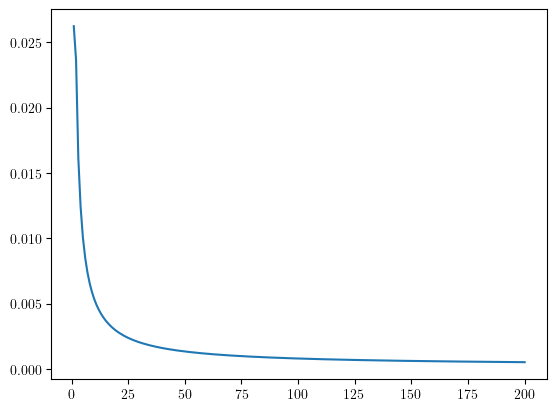

In [42]:
plt.plot([np.sum(df[15]['regret_bound'][:i])/(i) for i in range(201)])

python(26050) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(26078) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(26079) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(26080) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


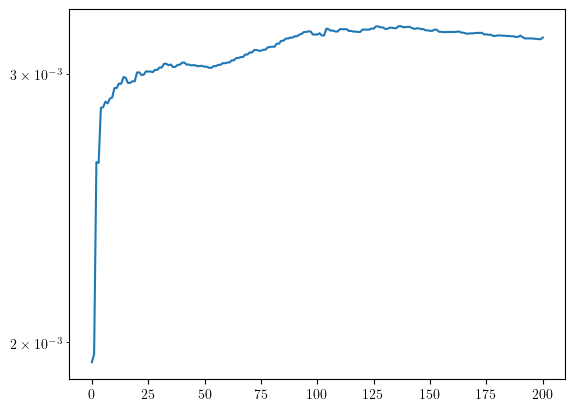

In [23]:
plt.plot(np.array(df[15]['sig_val'][:201]))
plt.yscale('log')

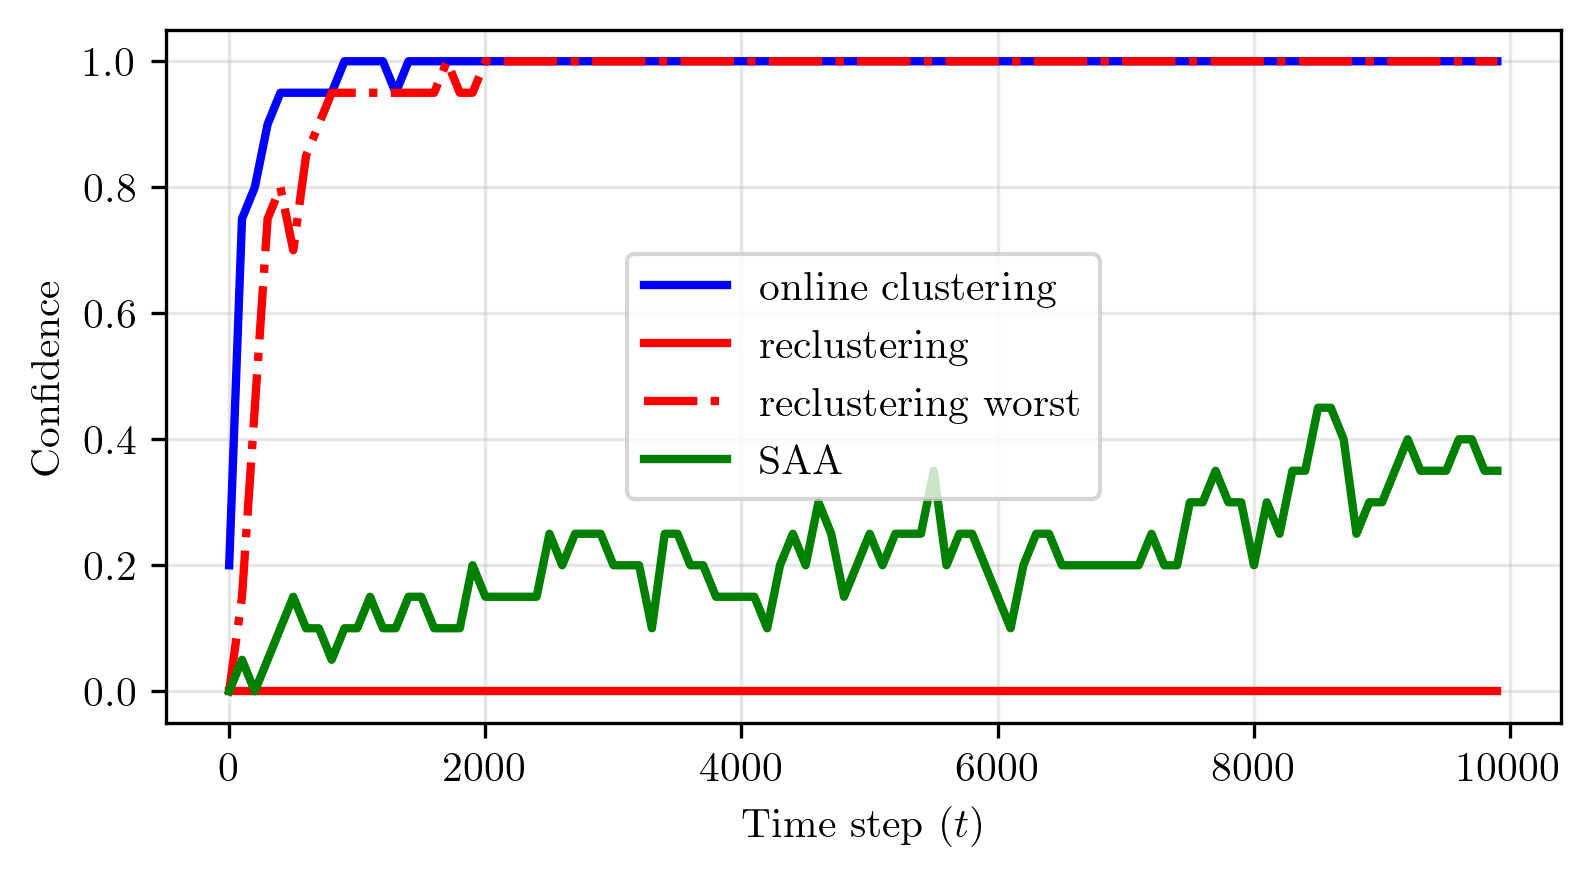

In [ ]:
plot_satisfy(df,j=(1,8,0),K=15,df1=df[0],dro=True,end_ind = 201)

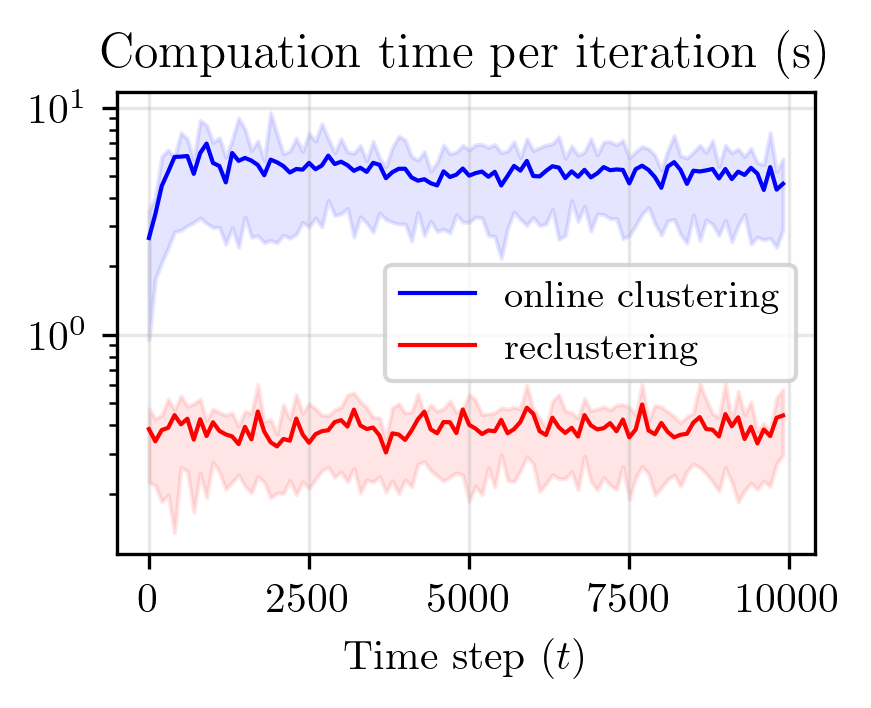

In [19]:
plot_computation_times_iter(df,quantiles,df[0],quantiles[0],j=(2,3,0),K=K,q=(25,75), end_ind = 201)

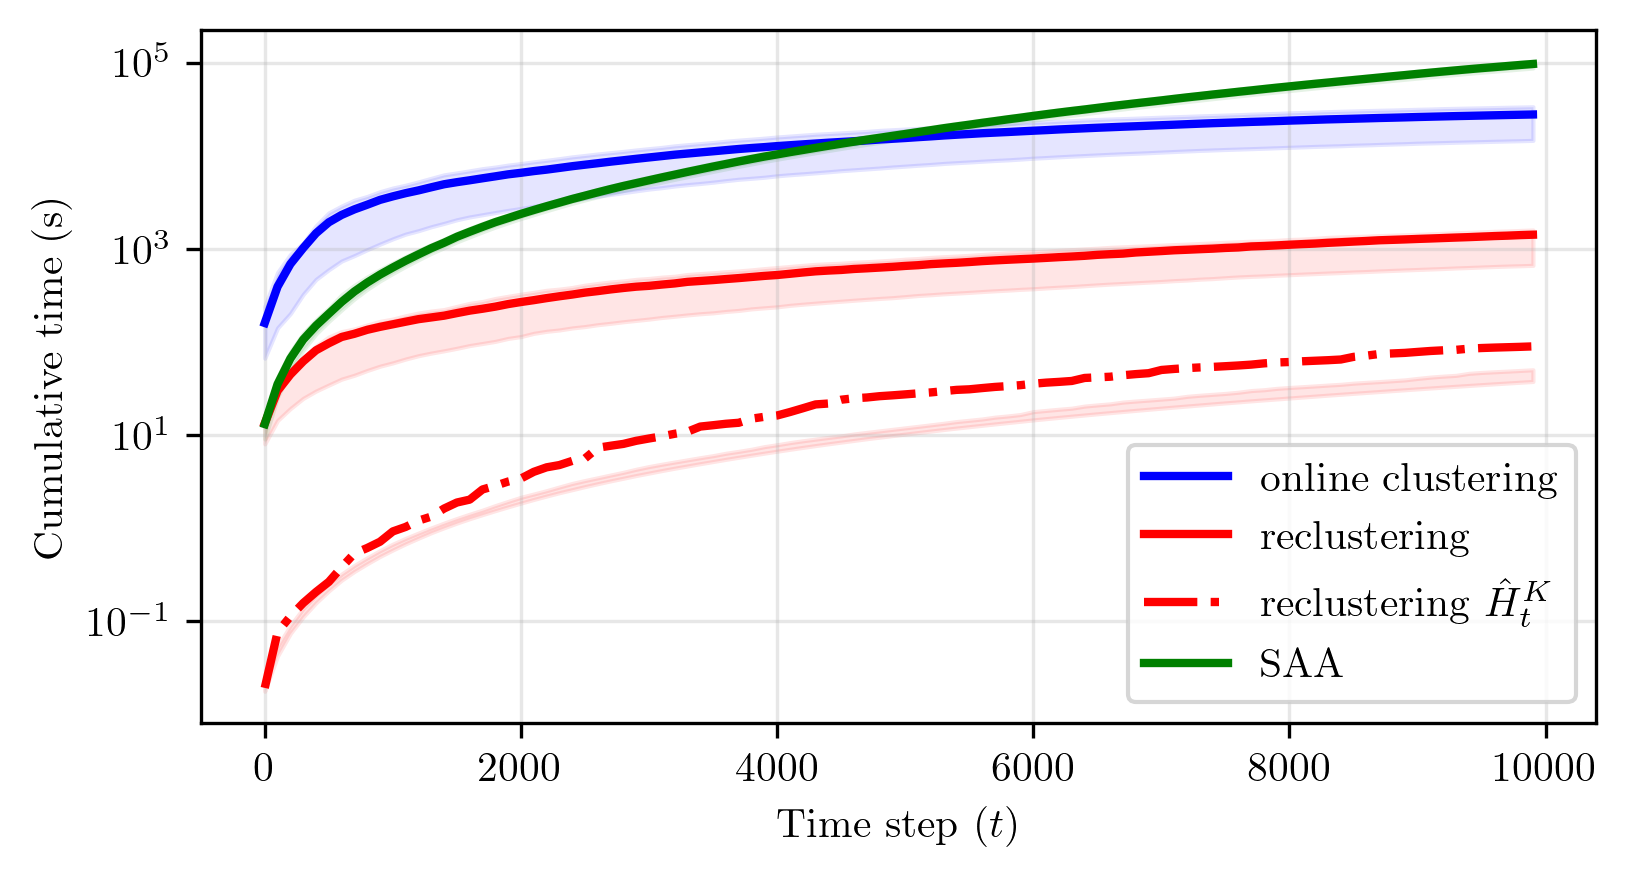

In [68]:
plot_computation_times_cum(df,quantiles,df[0],quantiles[0],j=(1,7,0),K=K,q=(25,75),dro=True,end_ind = 201)